# <b>Credit Card Fraud Detection</b>
Classification task: perform anomaly detection to detect fraudolent transactions.

1.   Download Credit Card Fraud dataset from Kaggle
2.   Analyse dataset
3.   Balance dataset
4.   Perform anomaly detection: the goal is to find the best combination of the classification method and the most performing sampling technique






## Environment setup



In [1]:
! pip install -q kaggle
from google.colab import files
# upload file kaggle.json (downloaded from Kaggle->My Account->API->Create new API token)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debcaldarola","key":"6465af324092036fd3f348c4dce29a4b"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

In [3]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 99% 65.0M/66.0M [00:00<00:00, 72.2MB/s]
100% 66.0M/66.0M [00:00<00:00, 90.3MB/s]


In [4]:
!mkdir data
!unzip creditcardfraud.zip -d data

Archive:  creditcardfraud.zip
  inflating: data/creditcard.csv     


## Dataset Analysis

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter
from numpy import where
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
# Define useful functions

def plot_2d_data_points(X, y, labels):
  colors = ['#1F77B4', '#FF7F0E']
  markers = ['o', '*']
  for label, color, marker in zip(np.unique(y), colors, markers):
    plt.scatter(X[y==label, 0], X[y==label, 1], c=color, label=label, marker=marker)
  plt.title(labels)
  plt.legend(loc='upper right')
  plt.show()

def print_results_table(matrix, rows, columns, title):
  fig = plt.figure(figsize=(10,1.5))
  ax = fig.add_subplot(1,1,1) 
  table = ax.table(cellText=matrix, rowLabels=rows, rowLoc='center', colLabels=columns, loc='center',
            colWidths=[0.5 for x in columns])
  table.set_fontsize(30)
  plt.subplots_adjust(left=0, bottom=0, top=3)
  plt.title(title, fontsize=30, loc='center')
  ax.axis('off')
  plt.show()

def print_bar_chart(x_labels, y_label, info_labels, values, title):
  n_labels = len(x_labels)
  n_values_per_label = len(info_labels)
  ind = np.arange(n_labels)
  width = 0.15

  fig, ax = plt.subplots(1,1, figsize=(12,7))
  plots = [None] * n_values_per_label
  values = np.array(values)
  
  for i in range(n_values_per_label):
    plots[i] = ax.bar(ind + i*width, values[:, i], width=width, label=info_labels[i])
  
  ax.set_title(title)
  ax.set_ylabel(y_label)
  ax.set_xticklabels(x_labels, fontsize=8)
  ax.set_xticks(ind + width * n_values_per_label / 2)
  ax.legend(plots, info_labels)
  
  plt.show()

In [7]:
data = pd.read_csv('data/creditcard.csv')
# Print data stats
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Not fraud:  99.83 %
Fraud:  0.17 %
Counter({0: 284315, 1: 492})


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  if sys.path[0] == '':


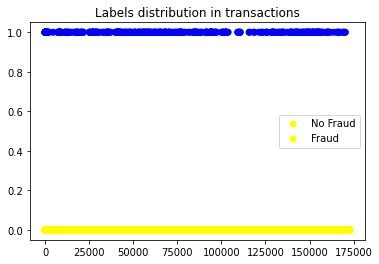

In [ ]:
# Print dataset balancing: highly unbalanced
print('Not fraud: ', round(data['Class'].value_counts()[0]/len(data) * 100, 2), '%')
print('Fraud: ', round(data['Class'].value_counts()[1]/len(data)*100, 2),'%')

counter = Counter(data['Class'].values)
print(counter)

color= ['yellow' if l == 0 else 'blue' for l in data['Class'].values]
scatter1 = plt.scatter(data['Time'], data['Class'], c=color)
scatter2 = plt.scatter(data['Amount'], data['Class'], c=color)
plt.title('Labels distribution in transactions')
plt.legend([scatter1, scatter2], labels=['No Fraud', 'Fraud'])
plt.show()

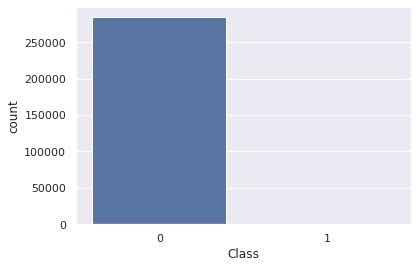

In [ ]:
# Class distribution
sns.set(style="darkgrid")
sns.countplot(x="Class", data=data)

[Text(0.5, 0, 'Transaction Elapsed Time')]

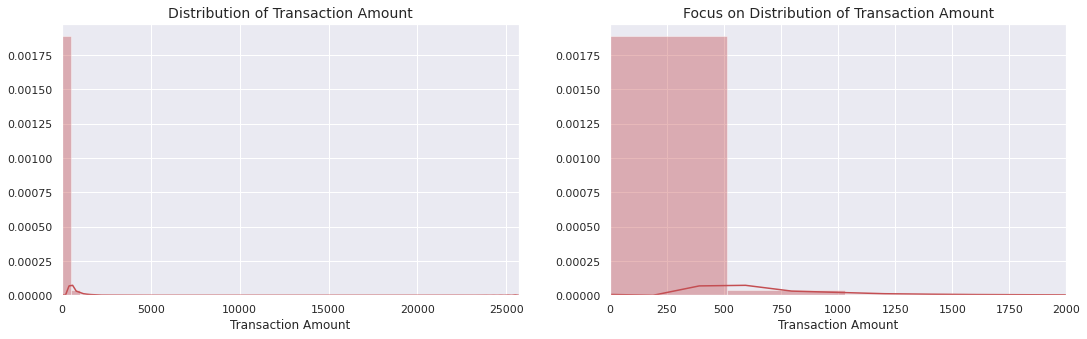

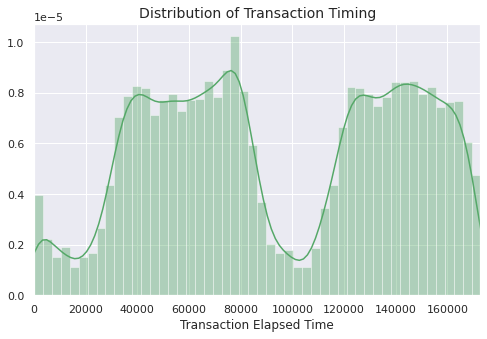

In [ ]:
# Amount and Time univariate distribution
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.distplot(data['Amount'].values, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(data['Amount'].values), max(data['Amount'].values)])
ax[0].set(xlabel='Transaction Amount')

sns.distplot(data['Amount'].values, ax=ax[1], color='r')
ax[1].set_title('Focus on Distribution of Transaction Amount', fontsize=14)
ax[1].set_xlim([min(data['Amount'].values), 2000])
ax[1].set(xlabel='Transaction Amount')

fig, ax = plt.subplots(1, 1, figsize=(8,5))
sns.distplot(data['Time'].values, ax=ax, color='g')
ax.set_title('Distribution of Transaction Timing', fontsize=14)
ax.set_xlim([min(data['Time'].values), max(data['Time'].values)])
ax.set(xlabel='Transaction Elapsed Time')

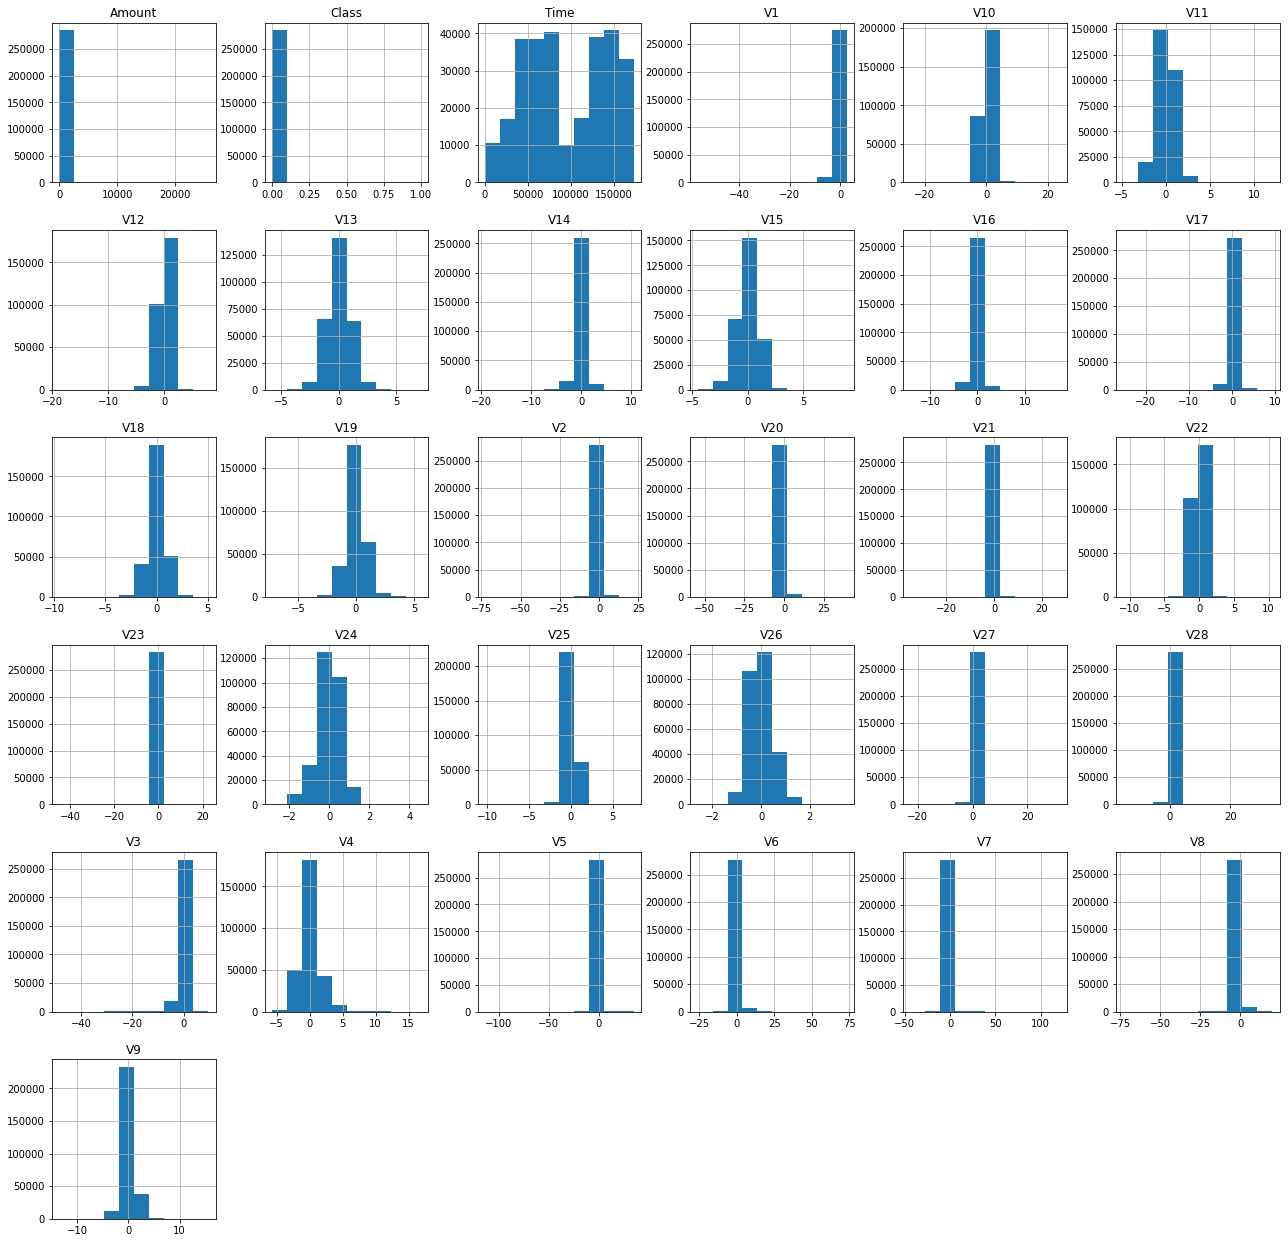

In [ ]:
# Plot features histograms
data.hist(figsize=(22,22))
plt.show() 

Text(0.5, 1.0, 'Unbalanced correlation matrix')

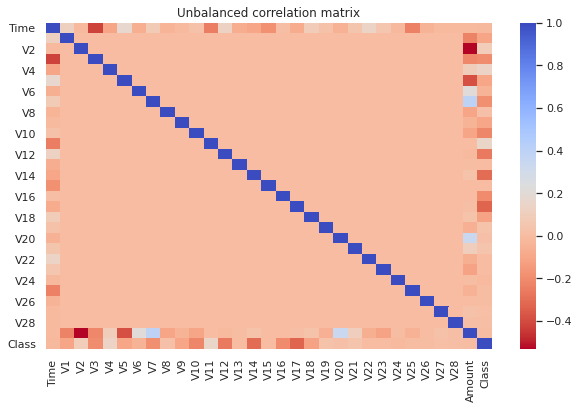

In [ ]:
# Unbalanced correlation matrix
fig, ax = plt.subplots(1,1,figsize=(10,6))
correlation = data.corr()
sns.heatmap(correlation, cmap='coolwarm_r', ax=ax)
ax.set_title('Unbalanced correlation matrix')

## From imbalanced to balanced dataset



In [8]:
# Create train and test split: undersampling and oversampling techniques must be only applied to the train set

data = data.sample(frac=1) # shuffle data
labels = data.columns.difference(['Class'])
X = data[labels]
print(X)
X = (X - X.mean()) / (X.max() - X.min())  # normalize X
print(X)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, stratify=y, random_state=42) # 'stratify=y' allows to create a test split with an equal percentage
# of positive and negative labels

# Create new dataframe with only train set data
df_x = pd.DataFrame(X_train)
df_y = pd.DataFrame(y_train)
new_data = pd.concat([df_x, df_y], axis=1)
print(new_data.columns)

X_train = X_train.values  # X_train still has the format of dataframe
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

# Normalize data
##X_train = preprocessing.normalize(X_train)
#X_test = preprocessing.normalize(X_test)

# Verify equal labels distribution in test and train splits
_, train_unique_labels = np.unique(y_train, return_counts=True) # returns the number of times each unique value comes up in the input array
_, test_unique_labels = np.unique(y_test, return_counts=True)

print('Labels distribution:')
print(train_unique_labels/len(y_train))
print(test_unique_labels/len(y_test))

        Amount      Time        V1  ...        V7        V8        V9
196030   14.23  131329.0  1.907484  ... -0.374687  0.186283 -0.579138
182558    1.29  125454.0  2.031677  ...  0.210710 -0.267797  0.391874
116655   66.16   74375.0 -0.864923  ...  0.608824  0.537899  0.707137
129170   33.33   78980.0 -1.350625  ...  0.594032  0.083820 -0.432956
234534    3.85  148014.0  2.205836  ...  0.852123 -0.604090  0.151221
...        ...       ...       ...  ...       ...       ...       ...
88823     9.87   62310.0 -0.560122  ...  0.671833  0.069711 -0.169784
183527   23.29  125842.0 -1.727351  ...  0.149264  1.023938  0.578243
273225  478.00  165490.0  1.215409  ... -0.116090 -0.018783 -0.669117
186374   11.50  127075.0  2.139163  ... -0.336639 -0.274582  0.149677
128480    9.23   78725.0  1.208200  ...  0.110721 -0.061502 -0.677267

[284807 rows x 30 columns]
          Amount      Time        V1  ...        V7        V8        V9
196030 -0.002885  0.211324  0.032406  ... -0.002283  0.00199

In [ ]:
print(new_data)

          Amount      Time        V1  ...        V8        V9  Class
271311 -0.000328  0.403376 -0.029353  ...  0.001166 -0.024308      0
100384 -0.002662 -0.158091 -0.029280  ... -0.002745 -0.014440      0
15522  -0.003362 -0.392963 -0.009224  ... -0.001060 -0.013620      0
26652  -0.002972 -0.350878  0.024375  ...  0.003008 -0.052785      0
139228 -0.003400 -0.067971 -0.013835  ...  0.007246  0.055276      0
...          ...       ...       ...  ...       ...       ...    ...
246445  0.043420  0.337760 -0.128326  ...  0.000428 -0.055560      0
116810 -0.003361 -0.117933  0.021650  ...  0.001479  0.009015      0
71600  -0.000364 -0.234136  0.018602  ...  0.000067 -0.021604      0
213798 -0.002935  0.258016  0.036097  ... -0.003293  0.013814      0
190213 -0.000350  0.196347 -0.011212  ... -0.000561 -0.046699      0

[227845 rows x 31 columns]


In [ ]:
n_labels = Counter(new_data['Class'].values)
print(n_labels)

Counter({0: 227451, 1: 394})


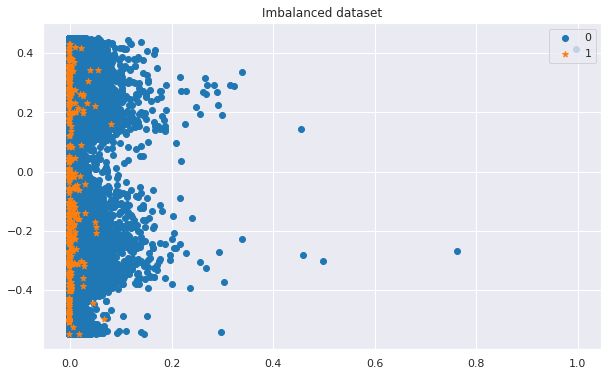

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_2d_data_points(X_train, y_train, 'Imbalanced dataset')

### Manual Random Sampling

#### Random Under-Sampling


Distribution of under-sampled data:
 1    0.5
0    0.5
Name: Class, dtype: float64


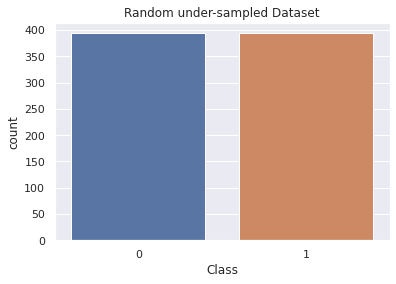

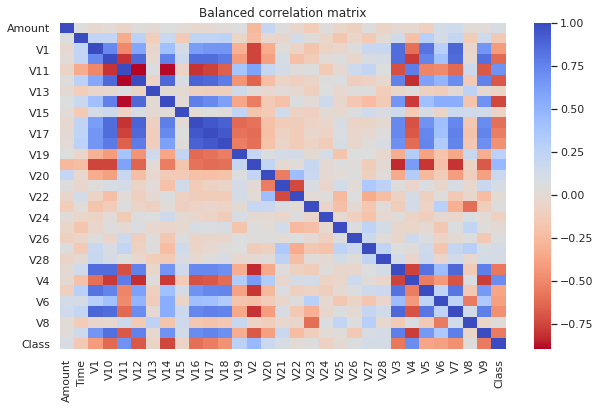

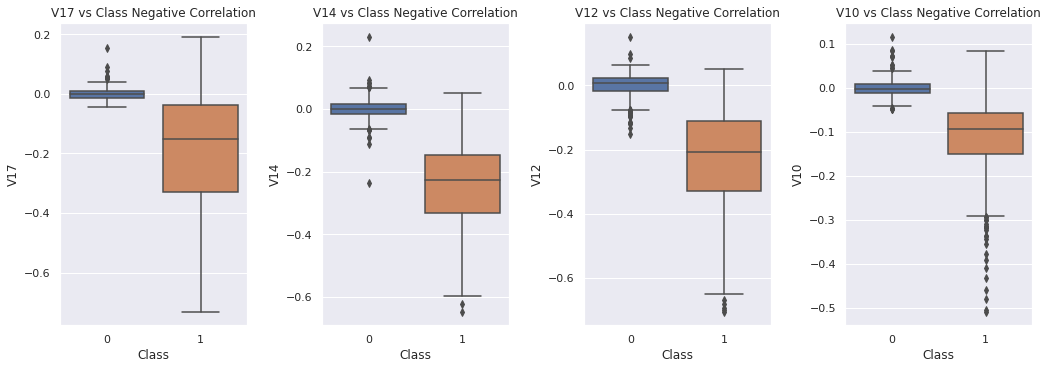

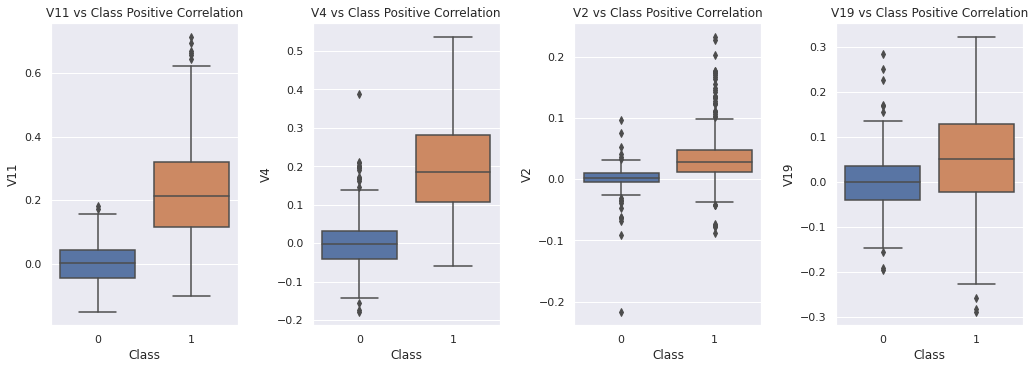

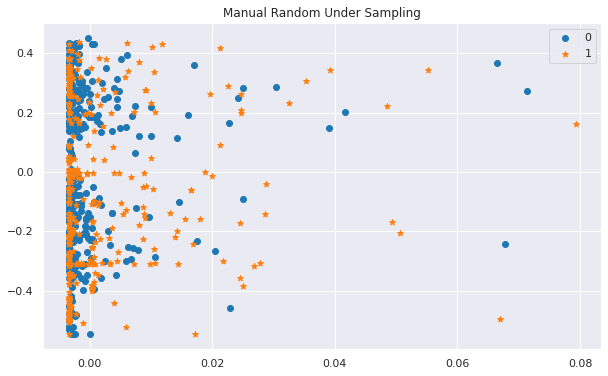

In [19]:
fraud_data = new_data.loc[new_data['Class'] == 1]
no_fraud_data = new_data.loc[new_data['Class'] == 0][:394] # take only number of samples = number of samples with label 1 (394)

under_sampled_data = pd.concat([fraud_data, no_fraud_data])
under_sampled_data = under_sampled_data.sample(frac=1, random_state = 0)  # random_state used for reproducibility

print('Distribution of under-sampled data:\n', under_sampled_data['Class'].value_counts()/len(under_sampled_data))

# Class distribution
sns.set(style="darkgrid")
sns.countplot(x="Class", data=under_sampled_data).set_title('Random under-sampled Dataset')

# Balanced correlation matrix
fig, ax = plt.subplots(1,1,figsize=(10,6))
correlation = under_sampled_data.corr()
sns.heatmap(correlation, cmap='coolwarm_r', ax=ax)
ax.set_title('Balanced correlation matrix')

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
fig, axes = plt.subplots(1,4, figsize=(15,5))
sns.boxplot(x="Class", y="V17", data=under_sampled_data, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V14", data=under_sampled_data, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V12", data=under_sampled_data, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')
sns.boxplot(x="Class", y="V10", data=under_sampled_data, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=0.95, hspace=0.25,
                    wspace=0.4)
plt.show()
# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
fig, axes = plt.subplots(1,4, figsize=(15,5))
sns.boxplot(x="Class", y="V11", data=under_sampled_data, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V4", data=under_sampled_data, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V2", data=under_sampled_data, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')
sns.boxplot(x="Class", y="V19", data=under_sampled_data, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=0.95, hspace=0.25,
                    wspace=0.4)
plt.show()

# Plot X,y after sampling
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_2d_data_points(under_sampled_data[labels].values, under_sampled_data['Class'].values, 'Manual Random Under Sampling')

#### Random Over-Sampling

Distribution of over-sampled data:
 1    0.5
0    0.5
Name: Class, dtype: float64


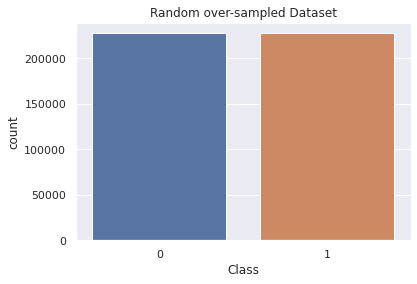

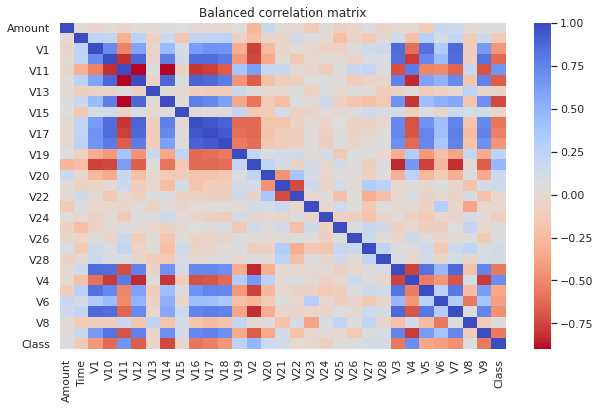

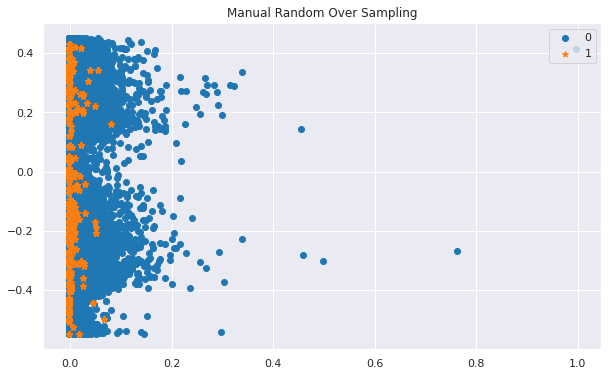

In [ ]:
n_nofraud, nfraud = new_data['Class'].value_counts()
fraud_data_over = fraud_data.sample(n_nofraud, replace=True)
no_fraud_data = new_data[new_data['Class'] == 0]

over_sampled_data = pd.concat([fraud_data_over, no_fraud_data], axis=0)

print('Distribution of over-sampled data:\n', over_sampled_data['Class'].value_counts()/len(over_sampled_data))

# Class distribution
sns.set(style="darkgrid")
sns.countplot(x="Class", data=over_sampled_data).set_title('Random over-sampled Dataset')

# Balanced correlation matrix
fig, ax = plt.subplots(1,1,figsize=(10,6))
correlation = over_sampled_data.corr()
sns.heatmap(correlation, cmap='coolwarm_r', ax=ax)
ax.set_title('Balanced correlation matrix')

# Plot X,y after sampling
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_2d_data_points(over_sampled_data[labels].values, over_sampled_data['Class'].values, 'Manual Random Over Sampling')

### Python imbalanced-learn module

#### Random under-sampling and over-sampling

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 394, 1: 394})


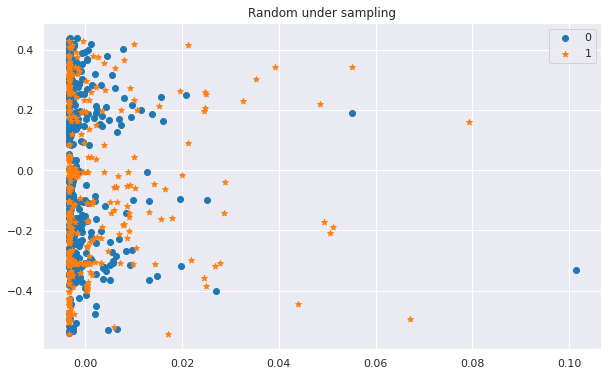

In [ ]:
# RandomUnderSampler
# Under-sample the majority class(es) by randomly picking samples with or without replacement

sampler = RandomUnderSampler(random_state=False, return_indices=True)
X_under_sampled, y_under_sampled, removed_idx = sampler.fit_resample(X_train, y_train)
#X_under_sampled, y_under_sampled, removed_idx = sampler.fit_resample(data[data.columns.difference(['Class'])].values, data['Class'].values)
#print('Removed indexes: ', removed_idx)
print(Counter(y_under_sampled))
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_2d_data_points(X_under_sampled, y_under_sampled, 'Random under sampling')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Total newly inserted samples:  227057
Counter({0: 227451, 1: 227451})


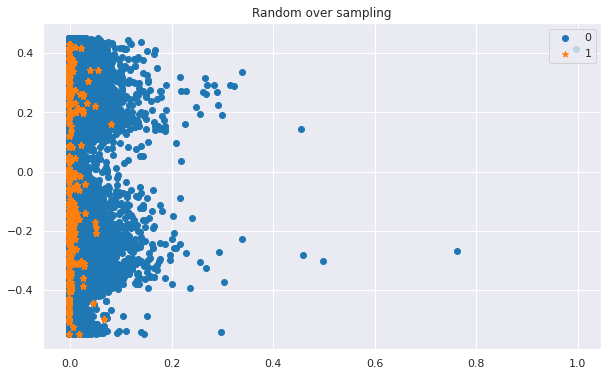

In [ ]:
# Random OverSampler

sampler = RandomOverSampler(random_state=0)
X_over_sampled, y_over_sampled = sampler.fit_resample(X_train, y_train)
print('Total newly inserted samples: ', X_over_sampled.shape[0] - X_train.shape[0])
print(Counter(y_over_sampled))
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_2d_data_points(X_over_sampled, y_over_sampled, 'Random over sampling')

#### Combining Random Over-Sampling and Under-Sampling


Previous situation: Counter({0: 227451, 1: 394})
After over sampling: Counter({0: 227451, 1: 22745})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After undersampling: Counter({0: 22745, 1: 22745})


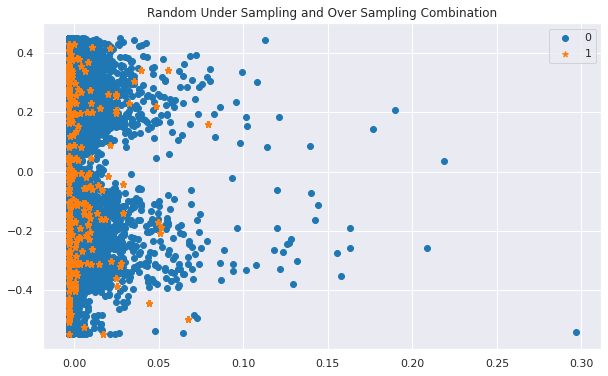

In [ ]:
print('Previous situation:', Counter(y_train))
over = RandomOverSampler(sampling_strategy=0.1, random_state=0)
# fit and apply the transform
X_mix, y_mix = over.fit_resample(X_train, y_train)
# summarize class distribution
print('After over sampling:', Counter(y_mix))
# define undersampling strategy
under = RandomUnderSampler(random_state=0)
# fit and apply the transform
X_mix, y_mix = under.fit_resample(X_mix, y_mix)
# summarize class distribution
print('After undersampling:', Counter(y_mix))
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_2d_data_points(X_mix, y_mix, 'Random Under Sampling and Over Sampling Combination')

#### SMOTE Algorithm (Synthetic Minority Oversampling Technique)
Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

Counter({0: 227451, 1: 394})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 227451, 1: 227451})


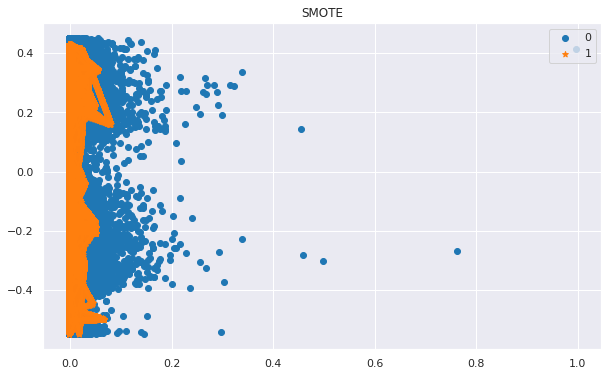

In [ ]:
sampler = SMOTE(random_state=0)
columns = new_data[labels].columns
print(Counter(y_train))
X_smote, y_smote = sampler.fit_resample(X_train, y_train)
print(Counter(y_smote))
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_2d_data_points(X_smote, y_smote, 'SMOTE')

## Anomaly Detection

Classification methods:
- Logistic Regression
- K-Nearest Neighbors
- Support Vector Machine
- Decision Tree
- Random Forest

In order to compare the different sampling techniques, each classifier is trained on the train set balanced with each one of them

### Parameters tuning

In [ ]:
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=0, max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(kernel='rbf', class_weight='balanced', random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(max_features='sqrt', max_depth=21, min_samples_leaf=1, min_samples_split=2)
}

# RBF kernel gives better results: https://www.researchgate.net/publication/236230678_A_Machine_Learning_Approach_for_Detection_of_Fraud_based_on_SVM
# C = 10: https://www.researchgate.net/publication/330475688_Bank_Fraud_Detection_Using_Support_Vector_Machine

clf_params_grid = {
    "LogisticRegression":{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    "KNN": {'n_neighbors': np.arange(1,22,5).tolist(), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    "Support Vector Classifier": {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
    "DecisionTreeClassifier": {'criterion': ['gini','entropy'], 'max_depth': np.arange(1,22,5).tolist(),'min_samples_split': [2,5,10],
                                'min_samples_leaf': [1, 2, 4]},
    "RandomForestClassifier" : {'n_estimators': [100, 2000]} # parameters list set according to results on decision tree parameters tuning
}
# n_estimators: Number of trees in random forest
# max_features: Number of features to consider at every split
# max_depth: Maximum number of levels in tree
# min_samples_split: Minimum number of samples required to split a node
# min_samples_leaf: Minimum number of samples required at each leaf node

X_train_splits = {
    "MyUnderSampler" : under_sampled_data[labels].values,
    "MyOverSampler" : over_sampled_data[labels].values,
    "RandomUnderSampler" : X_under_sampled,
    "RandomOverSampler" : X_over_sampled,
    "UnderAndOverSampler" : X_mix,
    "SMOTE" : X_smote 
}

y_train_splits = {
    "MyUnderSampler" : under_sampled_data['Class'].values,
    "MyOverSampler" : over_sampled_data['Class'].values,
    "RandomUnderSampler" : y_under_sampled,
    "RandomOverSampler" : y_over_sampled,
    "UnderAndOverSampler" : y_mix,
    "SMOTE" : y_smote 
}

In [ ]:
## Parameters fine tuning
# Metric: f1 score

for clfName, clf in classifiers.items():
  # tune classifier parameters
  clf = GridSearchCV(clf, param_grid=clf_params_grid[clfName], cv=3, scoring='f1', verbose=1, n_jobs=-1)
  for samplingTechnique in X_train_splits.keys():
    print("Training {:s} classifier on train set sampled with {:s} technique".format(clfName, samplingTechnique))
    clf.fit(X_train_splits[samplingTechnique], y_train_splits[samplingTechnique])
    print("{:s} best parameters: ".format(clfName))
    print(clf.best_params_)

[Grid Search Results](https://github.com/debcaldarola/Credit-Card-Fraud-Detection/blob/master/GridSearchResults.pdf)

### Classification

In [ ]:
## Train and test each classifier with fine tuned paramters on each train set sampled with a different technique

classifiers_fine_tuned = {
    "LogisticRegression": {
            "MyUnderSampler" : LogisticRegression(penalty='l2', C=1000, random_state=0, max_iter=1000),
            "MyOverSampler" : LogisticRegression(penalty='l2', C=1000, random_state=0, max_iter=1000),
            "RandomUnderSampler": LogisticRegression(penalty='l2', C=1000, random_state=0, max_iter=1000),
            "RandomOverSampler": LogisticRegression(penalty='l2', C=1000, random_state=0, max_iter=1000),
            "UnderAndOverSampler": LogisticRegression(penalty='l2', C=1000, random_state=0, max_iter=1000),
            "SMOTE" : LogisticRegression(penalty='l2', C=1000, random_state=0, max_iter=1000)
    },
    "KNN": {
            "MyUnderSampler": KNeighborsClassifier(n_neighbors=6, weights='distance', metric='euclidean'),
            "MyOverSampler": KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean'),
            "RandomUnderSampler": KNeighborsClassifier(n_neighbors=16, weights='distance', metric='manhattan'),
            "RandomOverSampler": KNeighborsClassifier(n_neighbors=16, weights='uniform', metric='euclidean'),
            "UnderAndOverSampler": KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean'),
            "SMOTE": KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')
    },
    "Support Vector Classifier": {
            "MyUnderSampler": SVC(C=10, gamma=1, kernel='rbf', class_weight='balanced'),
            "MyOverSampler": SVC(C=10, gamma=1, kernel='rbf', class_weight='balanced'),
            "RandomUnderSampler": SVC(C=10, gamma=1, kernel='rbf', class_weight='balanced'),
            "RandomOverSampler": SVC(C=10, gamma=1, kernel='rbf', class_weight='balanced'),
            "UnderAndOverSampler": SVC(C=10, gamma=1, kernel='rbf', class_weight='balanced'),
            "SMOTE": SVC(C=10, gamma=1, kernel='rbf', class_weight='balanced')
    },
    "DecisionTreeClassifier": {
            "MyUnderSampler": DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_split=2, min_samples_leaf=1),
            "MyOverSampler": DecisionTreeClassifier(criterion='gini', max_depth=21, min_samples_split=2, min_samples_leaf=2),
            "RandomUnderSampler": DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2, min_samples_leaf=2),
            "RandomOverSampler": DecisionTreeClassifier(criterion='gini', max_depth=21, min_samples_split=2, min_samples_leaf=2),
            "UnderAndOverSampler": DecisionTreeClassifier(criterion='gini', max_depth=21, min_samples_split=2, min_samples_leaf=1),
            "SMOTE": DecisionTreeClassifier(criterion='entropy', max_depth=21, min_samples_split=2, min_samples_leaf=1)
    },
    "RandomForestClassifier": {
            "MyUnderSampler": RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=21, min_samples_split=2, min_samples_leaf=1),
            "MyOverSampler": RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=21, min_samples_split=2, min_samples_leaf=1),
            "RandomUnderSampler": RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=21, min_samples_split=2, min_samples_leaf=1),
            "RandomOverSampler": RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=21, min_samples_split=2, min_samples_leaf=1),
            "UnderAndOverSampler": RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=21, min_samples_split=2, min_samples_leaf=1),
            "SMOTE": RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=21, min_samples_split=2, min_samples_leaf=1)
    }
}

In [ ]:
# Define structures for saving results
f1_scores_matrix = [[0]*len(X_train_splits.keys())]*len(classifiers.keys())
recalls_matrix = [[0]*len(X_train_splits.keys())]*len(classifiers.keys())

Training LogisticRegression classifier on train set sampled with MyUnderSampler technique
  Training time: 0.10 seconds
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.90      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962



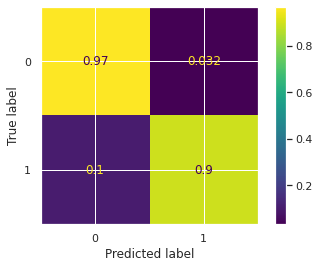

Training LogisticRegression classifier on train set sampled with MyOverSampler technique
  Training time: 55.42 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.89      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962



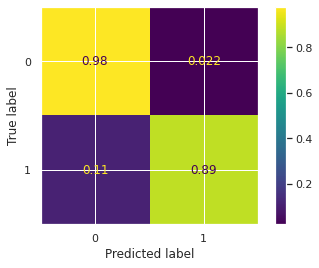

Training LogisticRegression classifier on train set sampled with RandomUnderSampler technique
  Training time: 0.11 seconds
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



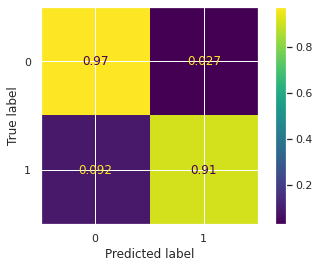

Training LogisticRegression classifier on train set sampled with RandomOverSampler technique
  Training time: 49.86 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.89      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.56     56962
weighted avg       1.00      0.98      0.99     56962



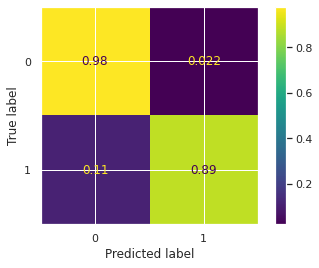

Training LogisticRegression classifier on train set sampled with UnderAndOverSampler technique
  Training time: 4.13 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.90      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



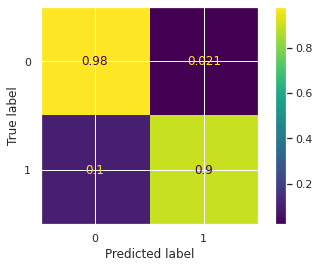

Training LogisticRegression classifier on train set sampled with SMOTE technique
  Training time: 57.20 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.88      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962



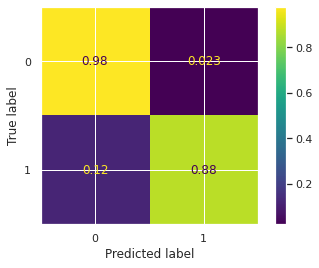

Training KNN classifier on train set sampled with MyUnderSampler technique
  Training time: 0.00 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.85      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.92      0.57     56962
weighted avg       1.00      0.98      0.99     56962



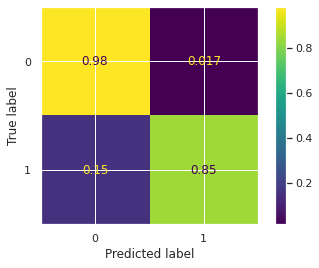

Training KNN classifier on train set sampled with MyOverSampler technique
  Training time: 4.10 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.76      0.82        98

    accuracy                           1.00     56962
   macro avg       0.95      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962



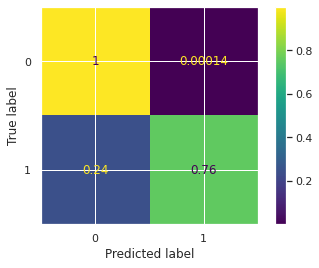

Training KNN classifier on train set sampled with RandomUnderSampler technique
  Training time: 0.00 seconds
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.20      0.84      0.32        98

    accuracy                           0.99     56962
   macro avg       0.60      0.92      0.66     56962
weighted avg       1.00      0.99      1.00     56962



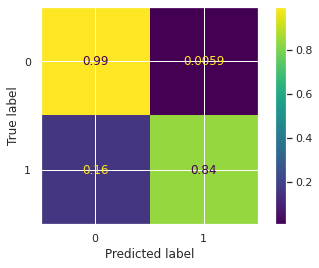

Training KNN classifier on train set sampled with RandomOverSampler technique
  Training time: 4.05 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.80      0.61        98

    accuracy                           1.00     56962
   macro avg       0.75      0.90      0.81     56962
weighted avg       1.00      1.00      1.00     56962



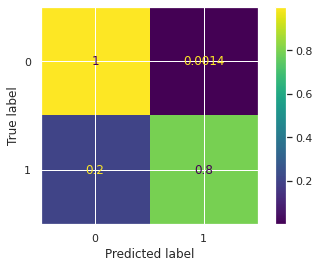

Training KNN classifier on train set sampled with UnderAndOverSampler technique
  Training time: 0.22 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.81      0.62        98

    accuracy                           1.00     56962
   macro avg       0.75      0.90      0.81     56962
weighted avg       1.00      1.00      1.00     56962



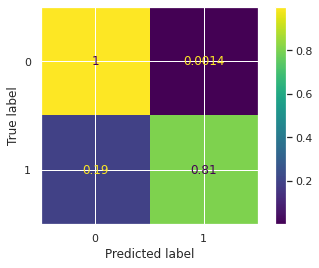

Training KNN classifier on train set sampled with SMOTE technique
  Training time: 4.09 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.81      0.80        98

    accuracy                           1.00     56962
   macro avg       0.90      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



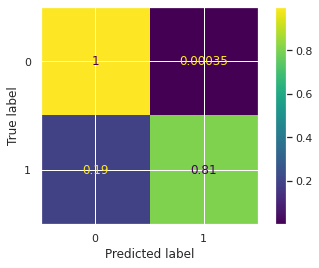

Training Support Vector Classifier classifier on train set sampled with MyUnderSampler technique
  Training time: 0.01 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.88      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.93      0.57     56962
weighted avg       1.00      0.98      0.99     56962



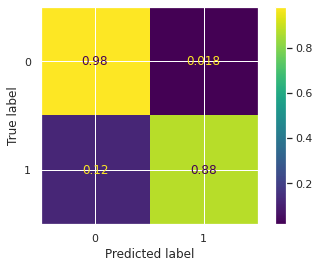

Training Support Vector Classifier classifier on train set sampled with MyOverSampler technique
  Training time: 6215.56 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.90      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962



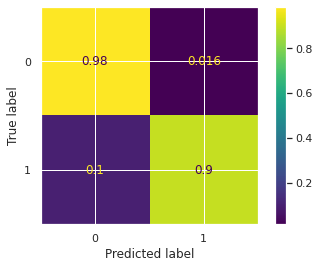

Training Support Vector Classifier classifier on train set sampled with RandomUnderSampler technique
  Training time: 0.01 seconds
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.88      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.93      0.60     56962
weighted avg       1.00      0.99      0.99     56962



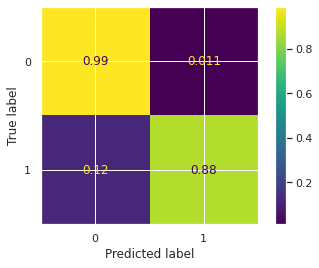

Training Support Vector Classifier classifier on train set sampled with RandomOverSampler technique
  Training time: 11985.60 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.90      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962



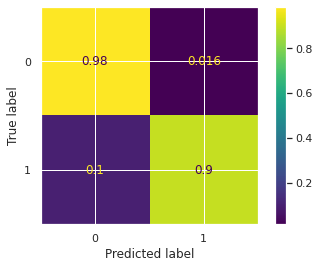

Training Support Vector Classifier classifier on train set sampled with UnderAndOverSampler technique
  Training time: 17.85 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962



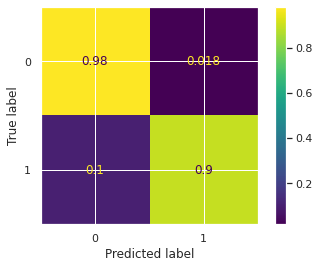

Training Support Vector Classifier classifier on train set sampled with SMOTE technique
  Training time: 1962.60 seconds
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.88      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962



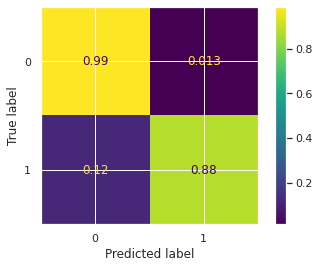

Training DecisionTreeClassifier classifier on train set sampled with MyUnderSampler technique
  Training time: 0.01 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.84      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.91      0.56     56962
weighted avg       1.00      0.98      0.99     56962



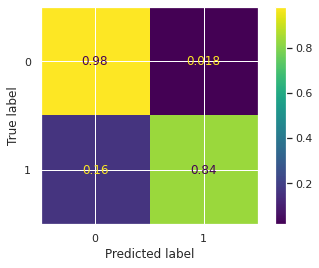

Training DecisionTreeClassifier classifier on train set sampled with MyOverSampler technique
  Training time: 12.01 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.55      0.78      0.64        98

    accuracy                           1.00     56962
   macro avg       0.77      0.89      0.82     56962
weighted avg       1.00      1.00      1.00     56962



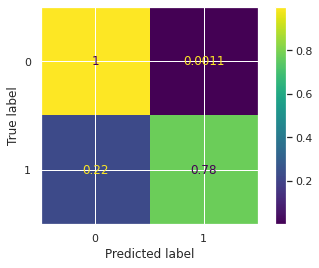

Training DecisionTreeClassifier classifier on train set sampled with RandomUnderSampler technique
  Training time: 0.02 seconds
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.89      0.03        98

    accuracy                           0.91     56962
   macro avg       0.51      0.90      0.49     56962
weighted avg       1.00      0.91      0.95     56962



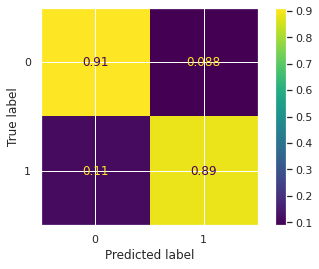

Training DecisionTreeClassifier classifier on train set sampled with RandomOverSampler technique
  Training time: 13.35 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.56      0.77      0.65        98

    accuracy                           1.00     56962
   macro avg       0.78      0.88      0.82     56962
weighted avg       1.00      1.00      1.00     56962



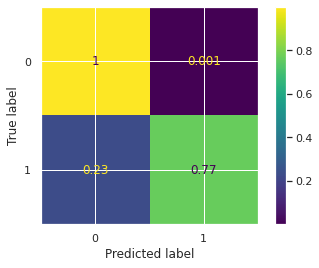

Training DecisionTreeClassifier classifier on train set sampled with UnderAndOverSampler technique
  Training time: 0.96 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.29      0.81      0.43        98

    accuracy                           1.00     56962
   macro avg       0.65      0.90      0.71     56962
weighted avg       1.00      1.00      1.00     56962



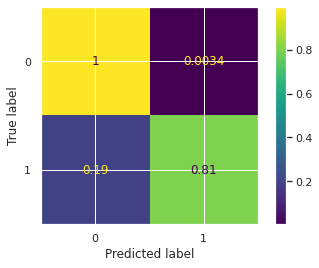

Training DecisionTreeClassifier classifier on train set sampled with SMOTE technique
  Training time: 26.47 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.81      0.45        98

    accuracy                           1.00     56962
   macro avg       0.66      0.90      0.72     56962
weighted avg       1.00      1.00      1.00     56962



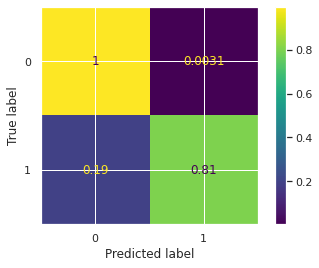

Training RandomForestClassifier classifier on train set sampled with MyUnderSampler technique
  Training time: 5.22 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.90      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



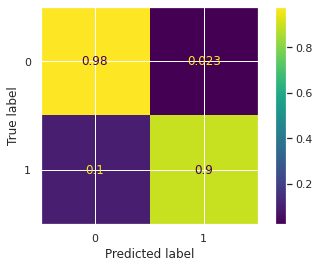

Training RandomForestClassifier classifier on train set sampled with MyOverSampler technique
  Training time: 158.71 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



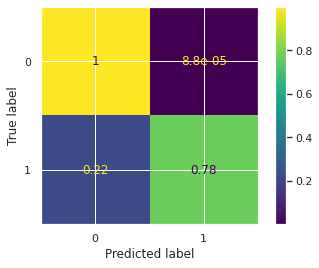

Training RandomForestClassifier classifier on train set sampled with RandomUnderSampler technique
  Training time: 5.23 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



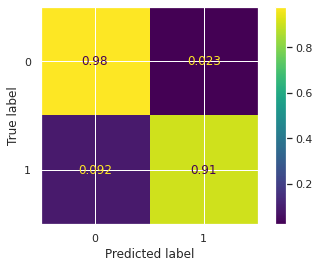

Training RandomForestClassifier classifier on train set sampled with RandomOverSampler technique
  Training time: 176.16 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.77      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



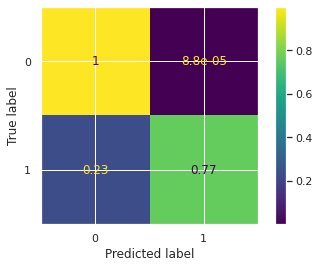

Training RandomForestClassifier classifier on train set sampled with UnderAndOverSampler technique
  Training time: 12.32 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.90      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



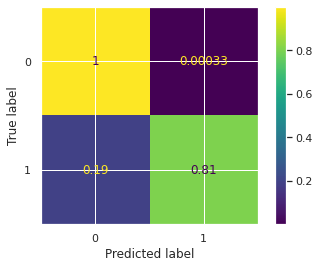

Training RandomForestClassifier classifier on train set sampled with SMOTE technique
  Training time: 7097.41 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.79      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962



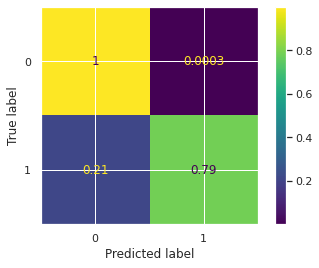

In [ ]:
y_true = y_test
i = 0
for clfName, clfDict in classifiers_fine_tuned.items():
  j = 0
  for samplingTechnique, clf in clfDict.items():
    print("Training {:s} classifier on train set sampled with {:s} technique".format(clfName, samplingTechnique))
    start = time.time()
    clf.fit(X_train_splits[samplingTechnique], y_train_splits[samplingTechnique])
    stop = time.time()
    print("  Training time: {:.2f} seconds".format(stop-start))
    y_pred = clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(clf, X_test, y_true, normalize='true')
    plt.show()
    f1_scores_matrix[i][j] = f1_score(y_true, y_pred, average='binary')
    recalls_matrix[i][j] = recall_score(y_true, y_pred, average='binary')  
    j += 1
  i += 1

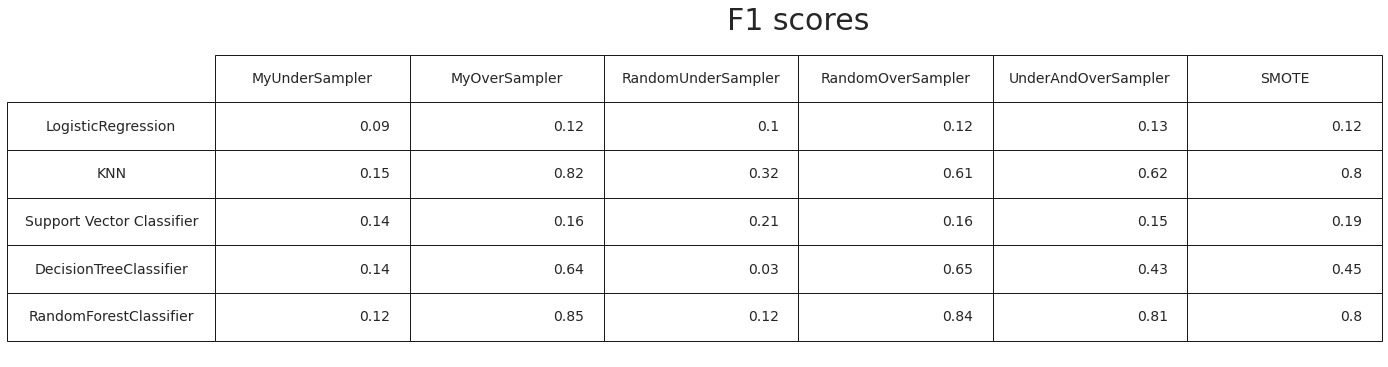

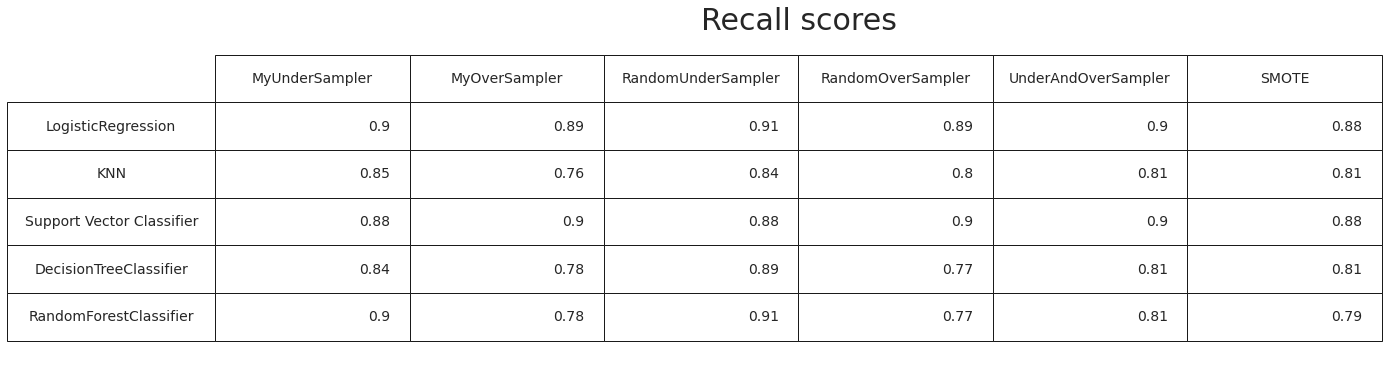

In [ ]:
print_results_table(f1_scores_matrix, list(classifiers.keys()), list(X_train_splits.keys()), 'F1 scores')
print_results_table(recalls_matrix, list(classifiers.keys()), list(X_train_splits.keys()), 'Recall scores')

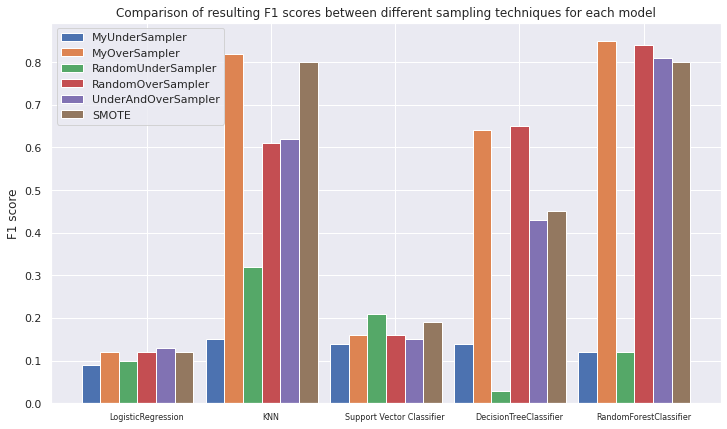

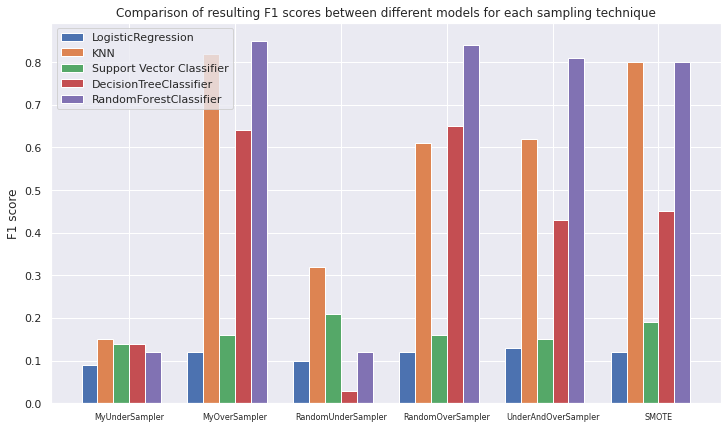

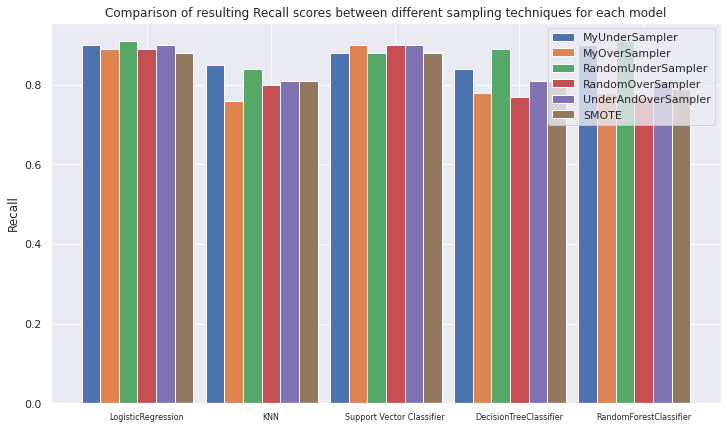

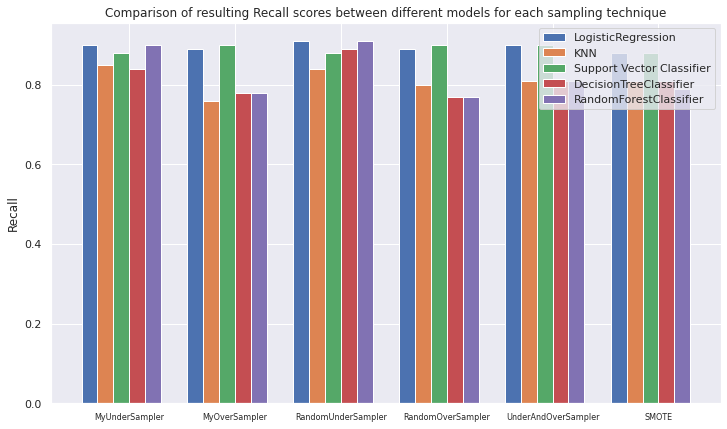

In [ ]:
### Compare results
## F1 score
print_bar_chart(list(classifiers.keys()), 'F1 score', list(X_train_splits.keys()), f1_scores_matrix, 
                'Comparison of resulting F1 scores between different sampling techniques for each model')

# Transpose column and rows
np_matrix = np.array(f1_scores_matrix)
transpose = np_matrix.T
f1_scores_by_sample = transpose.tolist()

print_bar_chart(list(X_train_splits.keys()), 'F1 score', list(classifiers.keys()), f1_scores_by_sample,
                'Comparison of resulting F1 scores between different models for each sampling technique')

## Recall
print_bar_chart(list(classifiers.keys()), 'Recall', list(X_train_splits.keys()), recalls_matrix, 
                'Comparison of resulting Recall scores between different sampling techniques for each model')

# Transpose column and rows
np_matrix = np.array(recalls_matrix)
transpose = np_matrix.T
recalls_by_sample = transpose.tolist()

print_bar_chart(list(X_train_splits.keys()), 'Recall', list(classifiers.keys()), recalls_by_sample,
                'Comparison of resulting Recall scores between different models for each sampling technique')


In [ ]:
print("Average results for each classifier")
print(np.mean(f1_scores_matrix, axis=1))
print(np.mean(recalls_matrix, axis=1))

print("\nAverage results for each sampling technique")
print(np.mean(f1_scores_matrix, axis=0))
print(np.mean(recalls_matrix, axis=0))

Average results for each classifier
[0.11333333 0.55333333 0.16833333 0.39       0.59      ]
[0.895      0.81166667 0.89       0.81666667 0.82666667]

Average results for each sampling technique
[0.128 0.518 0.156 0.476 0.428 0.472]
[0.874 0.822 0.886 0.826 0.846 0.834]


Best results:
- with respect to *F1 score* metric, the most performing classifier is **Random Forest** and according to averaging results the best sampling technique is manual **over-sampling**.
- with respect to *recall* metric, the most performing classifier is **Logistic Regression** and according to averaging results the best sampling technique is **random under-sampling**.